# 🧠 Mouse Model Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/mouseland/minimodel/blob/master/notebooks/mouse_pipeline.ipynb)

Welcome! This notebook walks through the training pipeline for the mouse model.

You'll start by training the full model using data from all neurons of a sample mouse.

Then, you'll train a minimodel that focuses on predicting the response of a single neuron from the same dataset.

# 0. Install dependencies (run if using colab)

In [1]:
# 🛠️ Install minimodel and dependencies

# !pip install --no-deps git+https://github.com/mouseland/minimodel.git

In [2]:
already_downloaded = True
if not already_downloaded:
    # Create a data directory
    !mkdir -p data
    !mkdir -p checkpoints

    # Download both files
    !wget -O data/FX8_nat60k_2023_05_16.npz https://janelia.figshare.com/ndownloader/files/53712320
    !wget -O data/nat60k_text16.mat https://janelia.figshare.com/ndownloader/files/53678783
    !wget -O checkpoints/FX8_051623_2layer_16_320_clamp_norm_depthsep_pool.pt https://github.com/MouseLand/minimodel/releases/download/V1.0.0/FX8_051623_2layer_16_320_clamp_norm_depthsep_pool.pt
    !wget -O checkpoints/FX8_051623_2layer_16_64_clamp_norm_depthsep_pool_nn3218_hs3e-02.pt https://github.com/MouseLand/minimodel/releases/download/V1.0.0/FX8_051623_2layer_16_64_clamp_norm_depthsep_pool_nn3218_hs3e-02.pt

# 1. load data
load images and the neural activity, then split the data into train and test.

In [3]:
import os
import torch
import numpy as np
from minimodel import data
import matplotlib.pyplot as plt

device = torch.device('cuda')

In [4]:
mouse_id = 4

data_path = './data'
weight_path = './checkpoints'
np.random.seed(1)

In [5]:
# load images
img = data.load_images(data_path, mouse_id, file=data.img_file_name[mouse_id])

raw image shape:  (68000, 66, 264)
cropped image shape:  (68000, 66, 130)
img:  (68000, 66, 130) -2.062947 2.088608 float32


In [6]:
# load neurons
fname = '%s_nat60k_%s.npz'%(data.db[mouse_id]['mname'], data.db[mouse_id]['datexp'])
spks, istim_train, istim_test, xpos, ypos, spks_rep_all = data.load_neurons(file_path = os.path.join(data_path, fname), mouse_id = mouse_id)
n_stim, n_neurons = spks.shape


loading activities from ./data/FX8_nat60k_2023_05_16.npz


In [7]:
# split train and validation set
itrain, ival = data.split_train_val(istim_train, train_frac=0.9)


splitting training and validation set...
itrain:  (32885,)
ival:  (3654,)


In [8]:
# normalize data
spks, spks_rep_all = data.normalize_spks(spks, spks_rep_all, itrain)


normalizing neural data...
finished


In [9]:
ineur = np.arange(0, n_neurons) #np.arange(0, n_neurons, 5)
spks_train = torch.from_numpy(spks[itrain][:,ineur]).to(device)
spks_val = torch.from_numpy(spks[ival][:,ineur]).to(device)

print('spks_train: ', spks_train.shape, spks_train.min(), spks_train.max())
print('spks_val: ', spks_val.shape, spks_val.min(), spks_val.max())

img_train = torch.from_numpy(img[istim_train][itrain]).to(device).unsqueeze(1) # change :130 to 25:100 
img_val = torch.from_numpy(img[istim_train][ival]).to(device).unsqueeze(1)
img_test = torch.from_numpy(img[istim_test]).to(device).unsqueeze(1)

print('img_train: ', img_train.shape, img_train.min(), img_train.max())
print('img_val: ', img_val.shape, img_val.min(), img_val.max())
print('img_test: ', img_test.shape, img_test.min(), img_test.max())

input_Ly, input_Lx = img_train.shape[-2:]

spks_train:  torch.Size([32885, 5804]) tensor(0., device='cuda:0') tensor(69.0541, device='cuda:0')
spks_val:  torch.Size([3654, 5804]) tensor(0., device='cuda:0') tensor(56.4533, device='cuda:0')
img_train:  torch.Size([32885, 1, 66, 130]) tensor(-2.0629, device='cuda:0') tensor(2.0886, device='cuda:0')
img_val:  torch.Size([3654, 1, 66, 130]) tensor(-2.0629, device='cuda:0') tensor(2.0886, device='cuda:0')
img_test:  torch.Size([500, 1, 66, 130]) tensor(-2.0629, device='cuda:0') tensor(2.0886, device='cuda:0')


# 2. fullmodel
build the two-layer full model (16-320) then train and test it.

In [10]:
# build model
from minimodel import model_builder
nlayers = 2
nconv1 = 16
nconv2 = 320
fullmodel, in_channels = model_builder.build_model(NN=len(ineur), n_layers=nlayers, n_conv=nconv1, n_conv_mid=nconv2)
model_name = model_builder.create_model_name(data.mouse_names[mouse_id], data.exp_date[mouse_id], n_layers=nlayers, in_channels=in_channels)

model_path = os.path.join(weight_path, model_name)
fullmodel = fullmodel.to(device)

core shape:  torch.Size([1, 320, 33, 65])
input shape of readout:  (320, 33, 65)
model name:  FX8_051623_2layer_16_320_clamp_norm_depthsep_pool.pt


In [11]:
# train model
from minimodel import model_trainer
if not os.path.exists(model_path):
    best_state_dict = model_trainer.train(fullmodel, spks_train, spks_val, img_train, img_val, device=device)
    torch.save(best_state_dict, model_path)
    print('saved model', model_path)
fullmodel.load_state_dict(torch.load(model_path))
print('loaded model', model_path)

loaded model ./checkpoints/FX8_051623_2layer_16_320_clamp_norm_depthsep_pool.pt


In [12]:
# test model
test_pred = model_trainer.test_epoch(fullmodel, img_test)
print('test_pred: ', test_pred.shape, test_pred.min(), test_pred.max())

test_pred:  (500, 5804) 0.008112609 7.2193575


In [13]:
from minimodel import metrics
test_fev, test_feve = metrics.feve(spks_rep_all, test_pred)

threshold = 0.15
print(f'filtering neurons with FEV > {threshold}')
valid_idxes = np.where(test_fev > threshold)[0]
print(f'valid neurons: {len(valid_idxes)} / {len(test_fev)}')
print(f'FEVE (test): {np.mean(test_feve[test_fev > threshold])}')

filtering neurons with FEV > 0.15
valid neurons: 2217 / 5804
FEVE (test): 0.6902266144752502


# 3. minimodel

In [14]:
# prepare data
ineuron = 3218
ineur = [ineuron]
spks_train = torch.from_numpy(spks[itrain][:,ineur])
spks_val = torch.from_numpy(spks[ival][:,ineur]) 
print('spks_train: ', spks_train.shape, spks_train.min(), spks_train.max())
print('spks_val: ', spks_val.shape, spks_val.min(), spks_val.max())

img_train = torch.from_numpy(img[istim_train][itrain]).to(device).unsqueeze(1) # change :130 to 25:100 
img_val = torch.from_numpy(img[istim_train][ival]).to(device).unsqueeze(1)
img_test = torch.from_numpy(img[istim_test]).to(device).unsqueeze(1)

print('img_train: ', img_train.shape, img_train.min(), img_train.max())
print('img_val: ', img_val.shape, img_val.min(), img_val.max())
print('img_test: ', img_test.shape, img_test.min(), img_test.max())

input_Ly, input_Lx = img_train.shape[-2:]

spks_train:  torch.Size([32885, 1]) tensor(0.) tensor(12.6959)
spks_val:  torch.Size([3654, 1]) tensor(0.) tensor(8.0651)
img_train:  torch.Size([32885, 1, 66, 130]) tensor(-2.0629, device='cuda:0') tensor(2.0886, device='cuda:0')
img_val:  torch.Size([3654, 1, 66, 130]) tensor(-2.0629, device='cuda:0') tensor(2.0886, device='cuda:0')
img_test:  torch.Size([500, 1, 66, 130]) tensor(-2.0629, device='cuda:0') tensor(2.0886, device='cuda:0')


In [15]:
# build model
from minimodel import model_builder
nlayers = 2
nconv1 = 16
nconv2 = 64
seed = 1
hs_readout = 0.03
wc_coef = 0.2
model, in_channels = model_builder.build_model(NN=1, n_layers=nlayers, n_conv=nconv1, n_conv_mid=nconv2, Wc_coef=wc_coef)
model_name = model_builder.create_model_name(data.mouse_names[mouse_id], data.exp_date[mouse_id], ineuron=ineur[0], n_layers=nlayers, in_channels=in_channels, seed=seed,hs_readout=hs_readout)

model_path = os.path.join(weight_path, model_name)
model = model.to(device)

core shape:  torch.Size([1, 64, 33, 65])
input shape of readout:  (64, 33, 65)
model name:  FX8_051623_2layer_16_64_clamp_norm_depthsep_pool_nn3218_hs3e-02.pt


In [16]:
# train model
from minimodel import model_trainer
if not os.path.exists(model_path):
    model.core.features.layer0.conv.weight.data = fullmodel.core.features.layer0.conv.weight.data.clone()
    model.core.features.layer0.conv.weight.requires_grad = False
    best_state_dict = model_trainer.train(model, spks_train, spks_val, img_train, img_val, device=device, l2_readout=0.2, hs_readout=hs_readout, n_epochs_period=[30, 30, 30, 30])
    torch.save(best_state_dict, model_path)
    print('saved model', model_path)
model.load_state_dict(torch.load(model_path))
print('loaded model', model_path)

loaded model ./checkpoints/FX8_051623_2layer_16_64_clamp_norm_depthsep_pool_nn3218_hs3e-02.pt


In [17]:
# test model
test_pred = model_trainer.test_epoch(model, img_test)
print('test_pred: ', test_pred.shape, test_pred.min(), test_pred.max())

test_pred:  (500, 1) 0.11383194 3.7337153


In [18]:
from minimodel import metrics
spks_rep = []
for i in range(len(spks_rep_all)):
    spks_rep.append(spks_rep_all[i][:,ineur])
test_fev, test_feve = metrics.feve(spks_rep, test_pred)
print('FEVE (test): ', np.mean(test_feve))

FEVE (test):  0.8226491


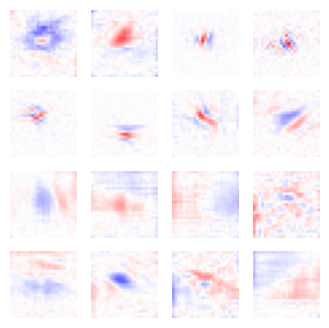

In [19]:
# visualize conv1 weights
conv1_w = model.core.features.layer0.conv.weight.data.cpu().numpy().squeeze()

from minimodel.utils import conv1_isort_all
conv1_isort = conv1_isort_all[mouse_id]
fig, ax = plt.subplots(4, 4, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(conv1_w[conv1_isort[i*4+j]], cmap='bwr', vmin=-0.5, vmax=0.5)
        ax[i, j].axis('off')

### 3.1 check Wc
Check the Wc weights in the readout, which determine the conv2 channels contribution to the prediction.

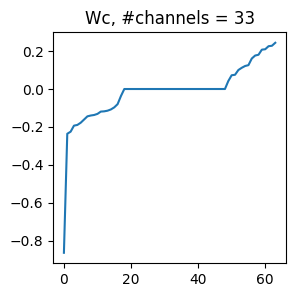

In [20]:
Wc = model.readout.Wc.detach().cpu().numpy().squeeze()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.plot(np.sort(Wc))
ax.set_title(f'Wc, #channels = {np.sum(np.abs(Wc) > 0.01)}')
plt.show()

### 3.2 visualize neuron
Visualize the top stimuli of the neuron, and the top stimuli of the conv2 channels that contribute mostly to the neuron.

In [21]:
# find the unique train images
Nimgs_unique = img_train.shape[0]

# get conv2 features of train images (in batches)
model.eval()
batch_size = 160
nconv2 = 64
conv2_fvs = np.zeros((Nimgs_unique, nconv2))
for i in range(0, Nimgs_unique, batch_size):
    images = img_train[i:i+batch_size].to(device)
    conv2_fv = model.core(images)
    wxy_fv = torch.einsum('iry, irx, ncyx -> ncr', model.readout.Wy, model.readout.Wx, conv2_fv).detach().cpu().numpy().squeeze()
    conv2_fvs[i:i+batch_size] = wxy_fv

# sort the features and select top 8 image for each channel
fv_isort = np.argsort(-conv2_fvs, axis=0)
Wc = model.readout.Wc.detach().cpu().numpy().squeeze()
ivalid_Wc = np.where(np.abs(Wc)>0.01)[0]
print('ivalid_Wc:', len(ivalid_Wc))
fv_isort = fv_isort[:, ivalid_Wc]
fv_isort_top8 = fv_isort[:8]
Nimg, Nchannel = fv_isort_top8.shape

# get mask of the images
from minimodel.utils import get_image_mask
ineuron_mask_up = get_image_mask(model, Ly=input_Ly, Lx=input_Lx)

# get predictions from the training set
neuron_activity_model = model_trainer.test_epoch(model, img_train)
neuron_activity_model = neuron_activity_model.squeeze()
prediction_isort = np.argsort(neuron_activity_model)[::-1]

ivalid_Wc: 33
rf size: 37.50
cutted_mask_up:  (47, 55)
35 90 5 52 (47, 55)


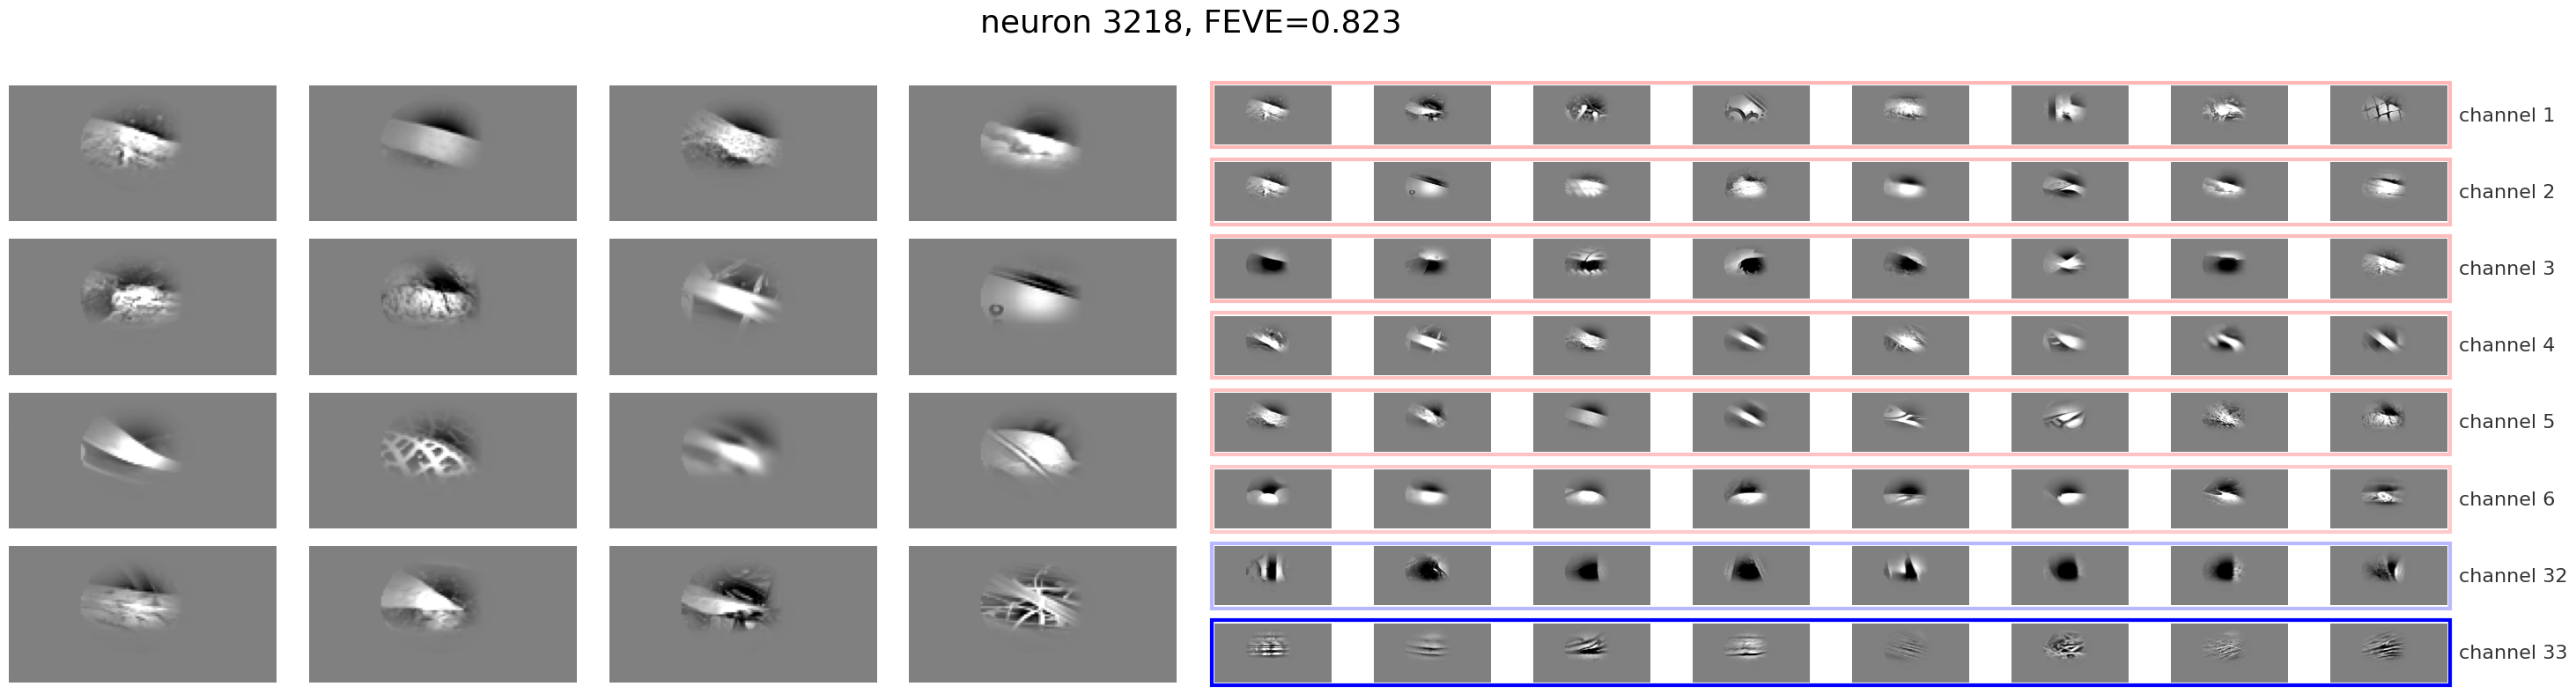

In [22]:
from minimodel.utils import add_channel_frame

# Parameters for the second plot
pad = 5
vmin = 0
vmax = 255
valid_wc = Wc[ivalid_Wc]
isort = np.argsort(valid_wc)[::-1]
Nchannel = 8
# Combined plot layout
fig = plt.figure(figsize=(Nimg * 2 + 20, Nchannel * 1.1))
gs = plt.GridSpec(Nchannel, Nimg + 4, figure=fig, hspace=0.3, wspace=0.1, width_ratios=[1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

# Plot one (4x4 grid on the left side, occupying 2 rows per row)
nshow = 16
for i in range(nshow):
    row = (i // 4) * 2
    col = i % 4
    ax = fig.add_subplot(gs[row:row + 2, col])
    ax.imshow(img_train[prediction_isort[i]].cpu().numpy().squeeze() * ineuron_mask_up, cmap='gray', vmin=-1, vmax=1)
    ax.axis('off')

# Plot two (8xNimg grid on the right side)
axs = np.empty((Nchannel, Nimg), dtype=object)
for i in range(Nchannel):
    if i < 6:
        ichannel = i
    else:
        ichannel = -(Nchannel - i)
    for j in range(Nimg):
        axs[i, j] = fig.add_subplot(gs[i, j + 4])
        # ax = axs[i, j + 4]  # Offset by 4 columns to place it on the right side
        axs[i, j].imshow(img_train[fv_isort_top8[j, isort[ichannel]]].cpu().numpy().squeeze() * ineuron_mask_up, cmap='gray', vmin=-1, vmax=1)
        axs[i, j].axis('off')
    wc_value = valid_wc[isort[ichannel]]
    # Determine the frame color and linewidth based on valid_wc[isort[ichannel]]
    if wc_value > 0:
        color = 'red'
    else:
        color = 'blue'
    add_channel_frame(axs, i, 0, Nimg - 1, color, np.abs(valid_wc[isort[ichannel]]/np.max(np.abs(valid_wc))))

    ax = axs[i, Nimg - 1]  # Rightmost axis in the row
    if ichannel < 0: ichannel = len(valid_wc) + ichannel
    ax.text(1.1, 0.5, f'channel {ichannel+1}', transform=ax.transAxes,
            verticalalignment='center', fontsize=16, color='black', alpha=0.8)
plt.suptitle(f'neuron {ineur[0]}, FEVE={test_feve[0]:.3f}', fontsize=26)
plt.show()